# Legal Document Summarization with LoRA Fine-tuning

## Setup and Environment Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Instead of using os.makedirs, use the shell command:
!mkdir -p /content/drive/MyDrive/legal_summarization_models1

MODEL_SAVE_PATH = "/content/drive/MyDrive/legal_summarization_models1"

# Install required packages
!pip install datasets transformers peft evaluate nltk matplotlib seaborn pandas wandb rouge-score
!pip install --upgrade accelerate
!pip install bert-score

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_kbit_training,
    PeftModel
)
import evaluate
import nltk
from nltk.tokenize import sent_tokenize
import gc
import wandb
from tqdm.auto import tqdm
from IPython.display import display, HTML
import itertools

# Download NLTK resources
nltk.download('punkt')

# Kaggle paths
INPUT_PATH = "/content/input"
OUTPUT_PATH = "/content"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Model and Training Configuration

In [ ]:
import wandb
wandb.login(key="c84100694af3b09f3b80db3936ffd12ed736cdb1")  # Add this before wandb.init()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ahmedabdelslam277 (ahmedabdelslam277-helwan-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Model configuration - Using BART
MODEL_NAME = "facebook/bart-large-cnn"  # Pre-trained on CNN/DailyMail for summarization
MAX_SOURCE_LENGTH = 1024
MAX_TARGET_LENGTH = 256
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 2
SAVE_EVERY_EPOCHS = 1  # Save model every 1 epoch

# LoRA configuration
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "out_proj"]  # Target attention modules

# Initialize wandb for experiment tracking
wandb.init(project="legal-document-summarization-lora")

## Loading and Preparing the Dataset
 loading the Pile of Law dataset and prepare it for our summarization task:

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("pile-of-law/pile-of-law", "all", split="train", streaming=True)

# Convert to an iterator and get a few samples
dataset_iter = iter(dataset)
sample = next(dataset_iter)

print(f"Sample data point: {sample}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

pile-of-law.py:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

The repository for pile-of-law/pile-of-law contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pile-of-law/pile-of-law.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/pile-of-law--pile-of-law/c1090502f95031ebfad49ede680394da5532909fa46b7a0452be8cddecc9fa60
INFO:datasets.info:Loading Dataset Infos from /root/.cache/huggingface/modules/datasets_modules/datasets/pile-of-law--pile-of-law/c1090502f95031ebfad49ede680394da5532909fa46b7a0452be8cddecc9fa60


Sample data point: {'text': 'Title: Landlord broke lease agreement, what are my rights? (Chicago, IL)\nQuestion:Our landlord has been promising us a washer/dryer unit since we moved in (July 2015). When we resigned the lease August 2016, we wrote into the lease that an in-unit washer and dryer would be installed by September 30th 2016.\n\nSince September 30th, there have been continuous delays in getting the W/D installed. Since it has now been almost a month past the date the W/D was supposed to be installed, I am wondering what types of rights as a tenant I have? \n\nThanks ahead of time for any and all advice given.\nAnswer #1: You can let your landlord know in writing that he is in default under the current lease agreement and give him a reasonable timeframe to cure his default.  \n\nIf he fails to correct the default, you can likely end your lease and move.', 'created_timestamp': '10-25-2016', 'downloaded_timestamp': '11-09-2021', 'url': 'https://www.reddit.com/r/legaladvice/comme

## Data Filtering and Preprocessing

In [ ]:
def filter_docs(example):
    # Get approximately documents between 1000-10000 characters
    text_length = len(example['text'])
    return 1000 <= text_length <= 10000

filtered_dataset = dataset.filter(filter_docs)

# For streaming datasets, we need to count manually or limit using take()
subset_size = 50000  # Adjust based on your computational resources
subset_dataset = filtered_dataset.take(subset_size)

# Convert to a list to check size and work with it
subset_list = list(itertools.islice(subset_dataset, subset_size))
print(f"Actual subset size: {len(subset_list)}")

# Sample from the subset
if subset_list:
    print(f"Sample data point: {subset_list[0]}")

Error reading file: https://huggingface.co/datasets/pile-of-law/pile-of-law/resolve/main/data/train.r_legaldvice.jsonl.xz
Actual subset size: 50000
Sample data point: {'text': "Title: I think someone is breaking into my car to get revenge for me being a bad driver six months ago\nQuestion:This is in Ohio. Back in May, I accidentally drove the wrong way down a fairly busy one way road because I had not taken my ADHD meds that day. Luckily no cars were coming towards me and as soon as I realized it, I drove in the bike lane for the rest of the block until I could turn. I was completely freaked out about it, so I decided to go back home and compose myself. I felt absolutely terrible about it. As I was driving home, I noticed a car following me. I started to take back roads and alleys to try to lose him for about 15 minutes, but I couldn’t. This freaked me out even more and I felt like I was too distracted to drive, so I decided to stick with the plan and go home. As soon as I got out of m

## Creating Summarization Dataset

In [ ]:
# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def prepare_summarization_data(examples):
    texts = examples["text"]
    summaries = []

    for text in texts:
        # Simple extractive summarization - take first few sentences
        sentences = sent_tokenize(text)

        # Take first 2-3 sentences as a "summary"
        num_summary_sentences = min(3, len(sentences))
        summary = " ".join(sentences[:num_summary_sentences])

        summaries.append(summary)

    return {"document": texts, "summary": summaries}

# Convert the IterableDataset to a regular Dataset
num_samples = 50000  # Adjust as needed
samples = []
for i, example in enumerate(filtered_dataset):
    if i >= num_samples:
        break
    samples.append(example)

# Create a regular Dataset from the samples
regular_dataset = Dataset.from_pandas(pd.DataFrame(samples))

# Apply the summarization function
summarization_dataset = regular_dataset.map(
    prepare_summarization_data,
    batched=True,
    batch_size=1000,
    remove_columns=regular_dataset.column_names
)

# Split into train, validation, and test
train_val_test_split = summarization_dataset.train_test_split(test_size=0.2)
train_dataset = train_val_test_split["train"]
temp_dataset = train_val_test_split["test"].train_test_split(test_size=0.5)
val_dataset = temp_dataset["train"]
test_dataset = temp_dataset["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Error reading file: https://huggingface.co/datasets/pile-of-law/pile-of-law/resolve/main/data/train.r_legaldvice.jsonl.xz


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train dataset size: 40000
Validation dataset size: 5000
Test dataset size: 5000


## Loading Tokenizer and Base Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,  # Load in half precision
    device_map="auto"  # Automatically decide which parts go to which devices
)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

## Prepare the Datasets for Training

In [ ]:
def preprocess_function(examples):
    inputs = examples["document"]
    targets = examples["summary"]

    model_inputs = tokenizer(
        inputs,
        max_length=MAX_SOURCE_LENGTH,
        padding="max_length",
        truncation=True
    )

    # Setup the tokenizer for targets
    labels = tokenizer(
        targets,
        max_length=MAX_TARGET_LENGTH,
        padding="max_length",
        truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]

    # Replace padding token id with -100 so it's ignored in loss calculation
    labels_with_ignore_index = []
    for labels_example in model_inputs["labels"]:
        labels_example = [label if label != tokenizer.pad_token_id else -100 for label in labels_example]
        labels_with_ignore_index.append(labels_example)

    model_inputs["labels"] = labels_with_ignore_index
    return model_inputs

# Process the datasets
processed_train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Processing train dataset",
)

processed_val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names,
    desc="Processing validation dataset",
)

processed_test_dataset = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_dataset.column_names,
    desc="Processing test dataset",
)

Processing train dataset:   0%|          | 0/40000 [00:00<?, ? examples/s]

Processing validation dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Processing test dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

## Define the Evaluation Metrics
using ROUGE and BERTScore to evaluate the model

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_NAME)

# Load evaluation metrics
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Decode generated summaries
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute ROUGE scores
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Extract ROUGE f1 scores
    result = {k: round(v * 100, 2) for k, v in rouge_result.items()}

    # Compute BERTScore (for semantic similarity)
    bertscore_result = bertscore.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        lang="en"
    )

    # Add BERTScore F1
    result["bertscore_f1"] = round(np.mean(bertscore_result["f1"]) * 100, 2)

    # Add mean generated length
    prediction_lens = [len(pred.split()) for pred in decoded_preds]
    result["gen_len"] = np.mean(prediction_lens)

    return result

## Prepare Model for LoRA Fine-tuning

In [ ]:
def prepare_for_lora_training(model):
    # Define LoRA Config
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=LORA_TARGET_MODULES,
        bias="none",
    )

    # Get the LoRA model
    model = get_peft_model(model, peft_config)

    # Print number of trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

    model.print_trainable_parameters()

    return model

# Apply LoRA to the base model
print("Applying LoRA to the base model...")
lora_model = prepare_for_lora_training(base_model)

Applying LoRA to the base model...
Trainable parameters: 4,718,592 (1.15% of total)
trainable params: 4,718,592 || all params: 411,009,024 || trainable%: 1.1481


## Callbacks for Training Monitoring and Model Saving

In [ ]:
from transformers.trainer_callback import TrainerCallback
import matplotlib.pyplot as plt

class SaveModelCallback(TrainerCallback):
    """Custom callback to save model checkpoints at specified intervals"""

    def __init__(self, trainer, save_path, save_every=1):
        self.trainer = trainer
        self.save_path = save_path
        self.save_every = save_every
        self.epoch_count = 0

    def on_train_begin(self, args, state, control, **kwargs):
        # This method is required but we don't need to do anything here
        pass

    def on_epoch_end(self, args, state, control, **kwargs):
        """Save model checkpoint at the end of specified epochs"""
        self.epoch_count += 1
        if self.epoch_count % self.save_every == 0:
            checkpoint_path = os.path.join(self.save_path, f"checkpoint-epoch-{self.epoch_count}")
            self.trainer.save_model(checkpoint_path)
            print(f"Model checkpoint saved to {checkpoint_path}")

class LossTrackingCallback(TrainerCallback):
    """Custom callback to track and plot loss during training"""

    def __init__(self):
        self.training_losses = []
        self.eval_losses = []
        self.steps = []
        self.eval_steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        # Track training loss
        if "loss" in logs and "step" in logs:
            self.training_losses.append(logs["loss"])
            self.steps.append(logs["step"])

        # Track evaluation loss
        if "eval_loss" in logs:
            self.eval_losses.append(logs["eval_loss"])
            self.eval_steps.append(state.global_step)

    def plot_losses(self, save_path=None):
        plt.figure(figsize=(10, 6))

        # Plot training loss
        if self.training_losses:
            plt.plot(self.steps, self.training_losses, label="Training Loss", color="blue")

        # Plot eval loss
        if self.eval_losses:
            plt.plot(self.eval_steps, self.eval_losses, label="Validation Loss", color="red", marker="o")

        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)

        if save_path:
            plt.savefig(save_path)

        plt.show()

## Set up Training Arguments and Trainer

In [ ]:
pip install --upgrade transformers


In [ ]:
import transformers
print(transformers.__version__)


4.51.3


In [ ]:
# Check your transformers version
import transformers
print(f"Transformers version: {transformers.__version__}")

# See the signature of Seq2SeqTrainingArguments
from inspect import signature
from transformers import Seq2SeqTrainingArguments
print(signature(Seq2SeqTrainingArguments))

Transformers version: 4.51.3
(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict, str, NoneType] = <factory>, warmup_ratio: 

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./models",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    report_to="wandb",
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    gradient_accumulation_steps=4,
    label_names=["labels"],  # Add this line
)



# Create our loss tracking callback
loss_tracker = LossTrackingCallback()

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=processed_train_dataset,
    eval_dataset=processed_val_dataset,
    processing_class=tokenizer,  # Corrected
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
        loss_tracker
    ]
)


# Add our custom model saving callback
save_callback = SaveModelCallback(trainer, MODEL_SAVE_PATH, save_every=SAVE_EVERY_EPOCHS)
trainer.add_callback(save_callback)

## Start Training

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bertscore F1,Gen Len
500,0.030700,0.058275,86.290000,85.490000,86.140000,86.240000,97.680000,61.765200
1000,0.017800,0.048051,87.710000,87.020000,87.600000,87.680000,97.910000,62.102400


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model checkpoint saved to /content/drive/MyDrive/legal_summarization_models1/checkpoint-epoch-1


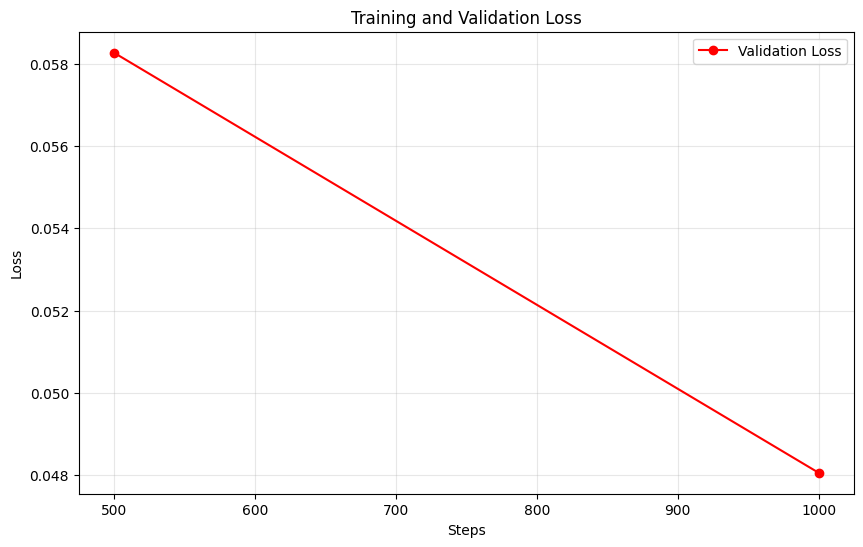

Final LoRA model saved to /content/drive/MyDrive/legal_summarization_models1/final_lora_model


In [ ]:
train_result = trainer.train()

# Plot and save the loss curves
loss_tracker.plot_losses(save_path=os.path.join(MODEL_SAVE_PATH, "loss_curves.png"))

# Save the final model
final_model_path = os.path.join(MODEL_SAVE_PATH, "final_lora_model")
trainer.save_model(final_model_path)
print(f"Final LoRA model saved to {final_model_path}")

\## Merge LoRA Weights with Base Model

In [ ]:
merged_model_path = os.path.join(MODEL_SAVE_PATH, "merged_lora_model")
os.makedirs(merged_model_path, exist_ok=True)

# Merge weights
merged_model = PeftModel.from_pretrained(base_model, final_model_path)
merged_model = merged_model.merge_and_unload()  # This merges LoRA weights with base model

# Save the merged model
merged_model.save_pretrained(merged_model_path)
tokenizer.save_pretrained(merged_model_path)
print(f"Merged model saved to {merged_model_path}")

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Merged model saved to /content/drive/MyDrive/legal_summarization_models1/merged_lora_model


## Evaluation Functions

In [ ]:
def generate_summary(model, text):
    inputs = tokenizer(text, return_tensors="pt", max_length=MAX_SOURCE_LENGTH, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=MAX_TARGET_LENGTH,
        num_beams=4,
        length_penalty=0.6,
        early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Comprehensive Evaluation Function
def evaluate_model_performance(model, dataset, name="Model", num_samples=100):
    """Evaluate model performance on a dataset"""
    if num_samples and len(dataset) > num_samples:
        eval_dataset = dataset.select(range(num_samples))
    else:
        eval_dataset = dataset

    results = {
        "rouge1": [],
        "rouge2": [],
        "rougeL": [],
        "bertscore_f1": [],
        "summary_length": [],
        "generation_time": []
    }

    all_predictions = []
    all_references = []

    for example in tqdm(eval_dataset, desc=f"Evaluating {name}"):
        document = example["document"]
        reference = example["summary"]

        # Measure generation time
        start_time = torch.cuda.Event(enable_timing=True)
        end_time = torch.cuda.Event(enable_timing=True)

        start_time.record()
        prediction = generate_summary(model, document)
        end_time.record()

        # Wait for GPU to finish
        torch.cuda.synchronize()
        generation_time = start_time.elapsed_time(end_time) / 1000  # Convert to seconds

        all_predictions.append(prediction)
        all_references.append(reference)

        # Calculate metrics for individual example
        rouge_scores = rouge.compute(
            predictions=[prediction],
            references=[reference],
            use_stemmer=True
        )

        bertscore_result = bertscore.compute(
            predictions=[prediction],
            references=[reference],
            lang="en"
        )

        # Store results
        results["rouge1"].append(rouge_scores["rouge1"] * 100)
        results["rouge2"].append(rouge_scores["rouge2"] * 100)
        results["rougeL"].append(rouge_scores["rougeL"] * 100)
        results["bertscore_f1"].append(bertscore_result["f1"][0] * 100)
        results["summary_length"].append(len(prediction.split()))
        results["generation_time"].append(generation_time)

    # Calculate aggregate metrics
    aggregated_results = {
        "rouge1": np.mean(results["rouge1"]),
        "rouge2": np.mean(results["rouge2"]),
        "rougeL": np.mean(results["rougeL"]),
        "bertscore_f1": np.mean(results["bertscore_f1"]),
        "avg_summary_length": np.mean(results["summary_length"]),
        "avg_generation_time": np.mean(results["generation_time"]),
        "model_name": name
    }

    return aggregated_results, all_predictions, all_references, results

## Evaluate Base Model and LoRA Model

In [ ]:
base_model_eval = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Evaluate on a subset of the test set
num_test_samples = 50  # Adjust based on computational resources

print("Evaluating the base model...")
base_results, base_preds, base_refs, base_detailed = evaluate_model_performance(
    base_model_eval,
    test_dataset,
    name="Base BART",
    num_samples=num_test_samples
)

print("Evaluating the LoRA fine-tuned model...")
lora_results, lora_preds, lora_refs, lora_detailed = evaluate_model_performance(
    merged_model,  # Use the merged model for evaluation
    test_dataset,
    name="LoRA BART",
    num_samples=num_test_samples
)

# Compile results
results_df = pd.DataFrame([base_results, lora_results])
print(results_df)

Evaluating the base model...


Evaluating Base BART:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating the LoRA fine-tuned model...


Evaluating LoRA BART:   0%|          | 0/50 [00:00<?, ?it/s]

      rouge1     rouge2     rougeL  bertscore_f1  avg_summary_length  \
0  42.137947  29.083614  35.267059     87.890921               56.72   
1  89.958686  89.404201  89.928152     98.275025               58.08   

   avg_generation_time model_name  
0            13.632048  Base BART  
1             1.315293  LoRA BART  


In [ ]:
# Save evaluation results to CSV
csv_output_path = "/content/evaluation_results.csv"
results_df.to_csv(csv_output_path, index=False)



## Visualizations

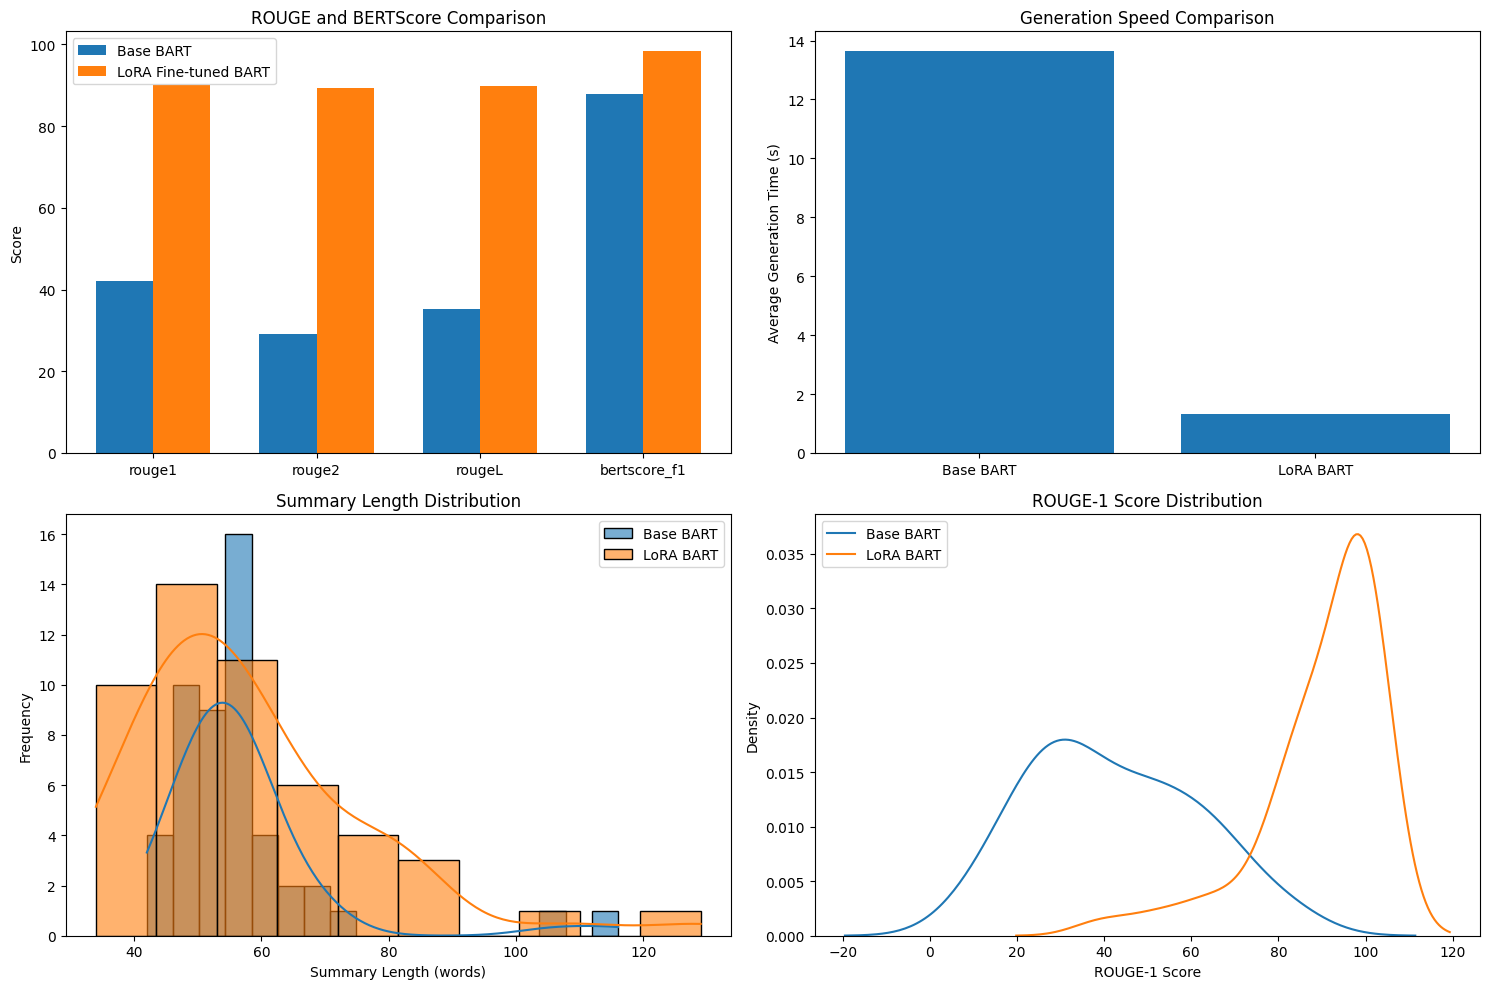

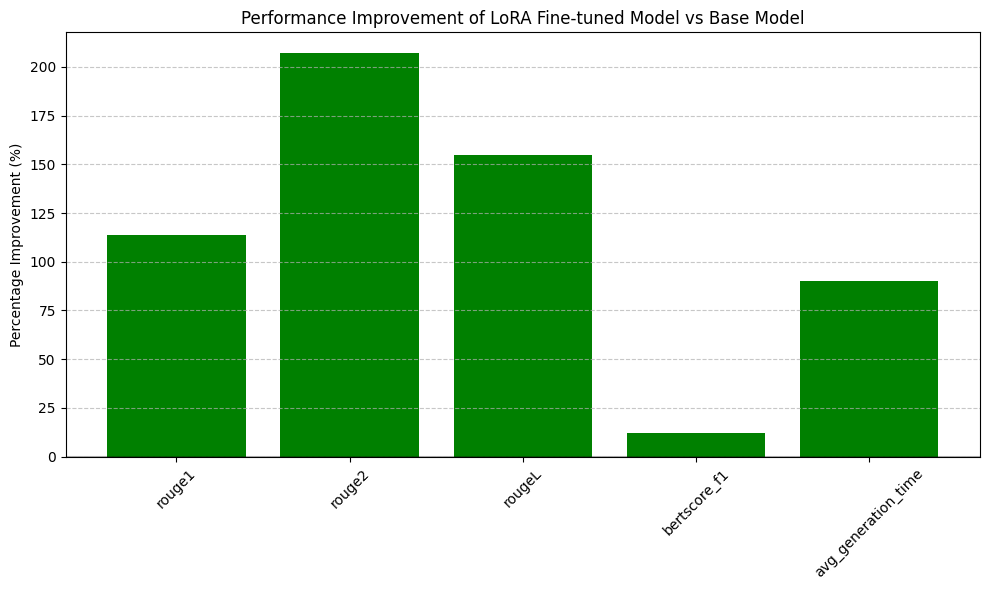

In [ ]:
plt.figure(figsize=(15, 10))

# ROUGE Scores Comparison
plt.subplot(2, 2, 1)
metrics = ["rouge1", "rouge2", "rougeL", "bertscore_f1"]
base_scores = [base_results[m] for m in metrics]
lora_scores = [lora_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, base_scores, width, label='Base BART')
plt.bar(x + width/2, lora_scores, width, label='LoRA Fine-tuned BART')
plt.ylabel('Score')
plt.title('ROUGE and BERTScore Comparison')
plt.xticks(x, metrics)
plt.legend()

# Generation Time Comparison
plt.subplot(2, 2, 2)
labels = ['Base BART', 'LoRA BART']
times = [base_results['avg_generation_time'], lora_results['avg_generation_time']]
plt.bar(labels, times)
plt.ylabel('Average Generation Time (s)')
plt.title('Generation Speed Comparison')

# Summary Length Distribution
plt.subplot(2, 2, 3)
sns.histplot(base_detailed['summary_length'], kde=True, label='Base BART', alpha=0.6)
sns.histplot(lora_detailed['summary_length'], kde=True, label='LoRA BART', alpha=0.6)
plt.xlabel('Summary Length (words)')
plt.ylabel('Frequency')
plt.title('Summary Length Distribution')
plt.legend()

# ROUGE-1 Score Distribution
plt.subplot(2, 2, 4)
sns.kdeplot(base_detailed['rouge1'], label='Base BART')
sns.kdeplot(lora_detailed['rouge1'], label='LoRA BART')
plt.xlabel('ROUGE-1 Score')
plt.ylabel('Density')
plt.title('ROUGE-1 Score Distribution')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'performance_comparison.png'))
plt.show()

# Create Performance Improvement Chart
improvement_metrics = {
    "rouge1": (lora_results["rouge1"] - base_results["rouge1"]) / base_results["rouge1"] * 100,
    "rouge2": (lora_results["rouge2"] - base_results["rouge2"]) / base_results["rouge2"] * 100,
    "rougeL": (lora_results["rougeL"] - base_results["rougeL"]) / base_results["rougeL"] * 100,
    "bertscore_f1": (lora_results["bertscore_f1"] - base_results["bertscore_f1"]) / base_results["bertscore_f1"] * 100,
    "avg_generation_time": (base_results["avg_generation_time"] - lora_results["avg_generation_time"]) / base_results["avg_generation_time"] * 100
}

plt.figure(figsize=(10, 6))
metrics = list(improvement_metrics.keys())
values = list(improvement_metrics.values())
colors = ['green' if v >= 0 else 'red' for v in values]

plt.bar(metrics, values, color=colors)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.ylabel('Percentage Improvement (%)')
plt.title('Performance Improvement of LoRA Fine-tuned Model vs Base Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'improvement_chart.png'))
plt.show()

## Testing

In [ ]:
def test_custom_text(model, custom_text):
    """Generate a summary for custom input text"""
    print("Generating summary for custom legal text...")
    print("\nInput text:")
    print("-" * 80)
    print(custom_text[:500] + "..." if len(custom_text) > 500 else custom_text)
    print("-" * 80)

    # Generate summary
    summary = generate_summary(model, custom_text)

    print("\nGenerated Summary:")
    print("-" * 80)
    print(summary)
    print("-" * 80)

    return summary


sample_legal_text = """
The United States District Court for the Southern District of New York (the "Court") entered a Final Judgment and Order of Dismissal approving the Settlement and dismissing the Action with prejudice. The Settlement resolves all claims in the Action.

The Settlement Class consists of all persons who purchased or otherwise acquired the common stock of Acme Corporation ("Acme" or the "Company") between January 1, 2020 and December 31, 2020, inclusive, and who were allegedly damaged thereby (the "Settlement Class"). Certain persons and entities are excluded from the Settlement Class as set forth in detail in the Settlement Agreement and in the Notice described below.

The Settlement provides that, in exchange for the settlement and release of the Released Claims against the Released Defendant Parties, a payment of $25,000,000 will be made for the benefit of the Settlement Class. After deduction of Court-awarded attorneys' fees and expenses, Notice and Administration Costs, and Taxes, the Net Settlement Fund will be distributed to eligible Settlement Class Members who submit valid Claim Forms that are accepted for payment by the Court in accordance with the proposed Plan of Allocation, or such other allocation plan as the Court may approve.

If you are a member of the Settlement Class, in order to be eligible to receive a payment under the proposed Settlement, you must submit a Claim Form postmarked (if mailed), or submitted online, no later than June 1, 2023. If you are a member of the Settlement Class and do not submit a proper Claim Form, you will not be eligible to share in the distribution of the net proceeds of the Settlement, but you will nevertheless be bound by any judgments or orders entered by the Court relating to the Settlement.

The Court has scheduled a Settlement Hearing for April 28, 2023 at 10:00 a.m. to consider, among other things, whether to approve the Settlement, the proposed Plan of Allocation, and Lead Counsel's application for attorneys' fees and reimbursement of expenses. The Settlement Hearing may be adjourned without further notice to the Settlement Class. You do NOT need to attend the Settlement Hearing to receive a distribution from the Net Settlement Fund.
"""

# Test with both base model and fine-tuned model
print("Testing with base BART model:")
base_summary = test_custom_text(base_model_eval, sample_legal_text)

print("\n\nTesting with LoRA fine-tuned BART model:")
lora_summary = test_custom_text(merged_model, sample_legal_text)

# Compare summaries
print("\nComparison of Summaries:")
print("-" * 80)
print(f"Base BART: {base_summary}")
print("-" * 40)
print(f"LoRA BART: {lora_summary}")
print("-" * 80)

Testing with base BART model:
Generating summary for custom legal text...

Input text:
--------------------------------------------------------------------------------

The United States District Court for the Southern District of New York (the "Court") entered a Final Judgment and Order of Dismissal approving the Settlement and dismissing the Action with prejudice. The Settlement resolves all claims in the Action.

The Settlement Class consists of all persons who purchased or otherwise acquired the common stock of Acme Corporation ("Acme" or the "Company") between January 1, 2020 and December 31, 2020, inclusive, and who were allegedly damaged thereby (the "S...
--------------------------------------------------------------------------------

Generated Summary:
--------------------------------------------------------------------------------
The Settlement Class consists of all persons who purchased or otherwise acquired the common stock of Acme Corporation between January 1, 2020 and 

In [ ]:
import json

# Compare summaries
comparison = {
    "input_text_excerpt": sample_legal_text[:500] + "..." if len(sample_legal_text) > 500 else sample_legal_text,
    "base_bart_summary": base_summary,
    "lora_bart_summary": lora_summary
}

# Save to JSON
output_path = "/content/summary_comparison.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(comparison, f, indent=4, ensure_ascii=False)

print(f"\nSummaries saved to {output_path}")



Summaries saved to /content/summary_comparison.json


In [ ]:
import shutil

model_zip_path = os.path.join(OUTPUT_PATH, "legal_summarizer_model.zip")
shutil.make_archive(
    os.path.join(OUTPUT_PATH, "legal_summarizer_model"),
    'zip',
    merged_model_path
)

print(f"Model exported for download at: {model_zip_path}")
print("You can download this file from the Kaggle output panel.")

Model exported for download at: /content/legal_summarizer_model.zip
You can download this file from the Kaggle output panel.
